<a href="https://colab.research.google.com/github/michellecxy015/youtube/blob/main/code/youtube_network_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install gravis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.1/659.1 kB 7.0 MB/s eta 0:00:00


In [13]:
import networkx as nx
import gravis as gv
from matplotlib.colors import to_hex, ListedColormap
from matplotlib import cm
from collections import Counter
from networkx.algorithms.community import greedy_modularity_communities

In [5]:
import gravis as gv
import networkx as nx
import pandas as pd
file_path = '/content/youtube_recommendation_network_1.csv'
df = pd.read_csv(file_path)

In [6]:
seed_list=['OJ6yd5mmuAU', '_36bHzl-PV0', '8D4SjiKazqk', 'P3RWXEvaiwo', 'AQ6GmpMu5L8']

#depth<=10

In [19]:
# Network Construction

# Initialize a directed graph
G1 = nx.DiGraph()

# Dictionary to track edge frequencies
edge_frequencies = {}

# Add nodes and edges with attributes
for _, row in df.iterrows():
    source = row['Source Video ID']
    target = row['Target Video ID']

    # Track edge frequencies
    if (source, target) not in edge_frequencies:
        edge_frequencies[(source, target)] = 0
    edge_frequencies[(source, target)] += 1

    # Add source and target nodes
    G1.add_node(source)
    G1.add_node(target)

    # Add edges with attributes
    edge_color = "red" if source == target else "black"  # Mark self-loops as red
    G1.add_edge(source, target, size=edge_frequencies[(source, target)], color=edge_color)

In [20]:


# Compute modularity classes using greedy_modularity_communities
communities = greedy_modularity_communities(G1.to_undirected())  # Convert to undirected for modularity computation
modularity_classes = {node: idx for idx, community in enumerate(communities) for node in community}  # Map nodes to community IDs
modularity_colors = cm.tab20c.colors  # Predefined color palette for modularity

# Map modularity classes to colors
class_to_color = {mod_class: to_hex(modularity_colors[i % len(modularity_colors)]) for i, mod_class in enumerate(set(modularity_classes.values()))}

# Update node attributes
base_size = 50
influence_multiplier = 3000  # Amplify influence for larger nodes
for node in G1.nodes:
    # Assign size based on centrality
    centrality = nx.in_degree_centrality(G1)[node]
    G1.nodes[node]["size"] = base_size + (centrality * influence_multiplier)

    # Assign color
    if node in seed_list:
        G1.nodes[node]["color"] = "black"  # Seed nodes are black
        G1.nodes[node]["label"] = node  # Show label for seed nodes
        G1.nodes[node]["title"] = f"Seed: {node}"
    else:
        # Non-seed nodes get modularity-based color
        mod_class = modularity_classes.get(node, 0)  # Default to modularity class 0 if not found
        G1.nodes[node]["color"] = class_to_color[mod_class]
        G1.nodes[node]["label"] = ""  # Hide labels for non-seed nodes
        G1.nodes[node]["title"] = f"Video ID: {node}, Modularity Class: {mod_class}"  # Tooltip

# Update edge thickness based on raw frequency
for source, target, data in G1.edges(data=True):
    raw_width = edge_frequencies[(source, target)]  # Use raw edge frequency
    data["width"] = max(2, raw_width)  # Ensure a minimum width of 2 for visibility
    if data.get("color") == "red":  # Preserve red for self-loops
        data["color"] = "red"

# Visualize the graph using Gravis
gv.d3(G1)


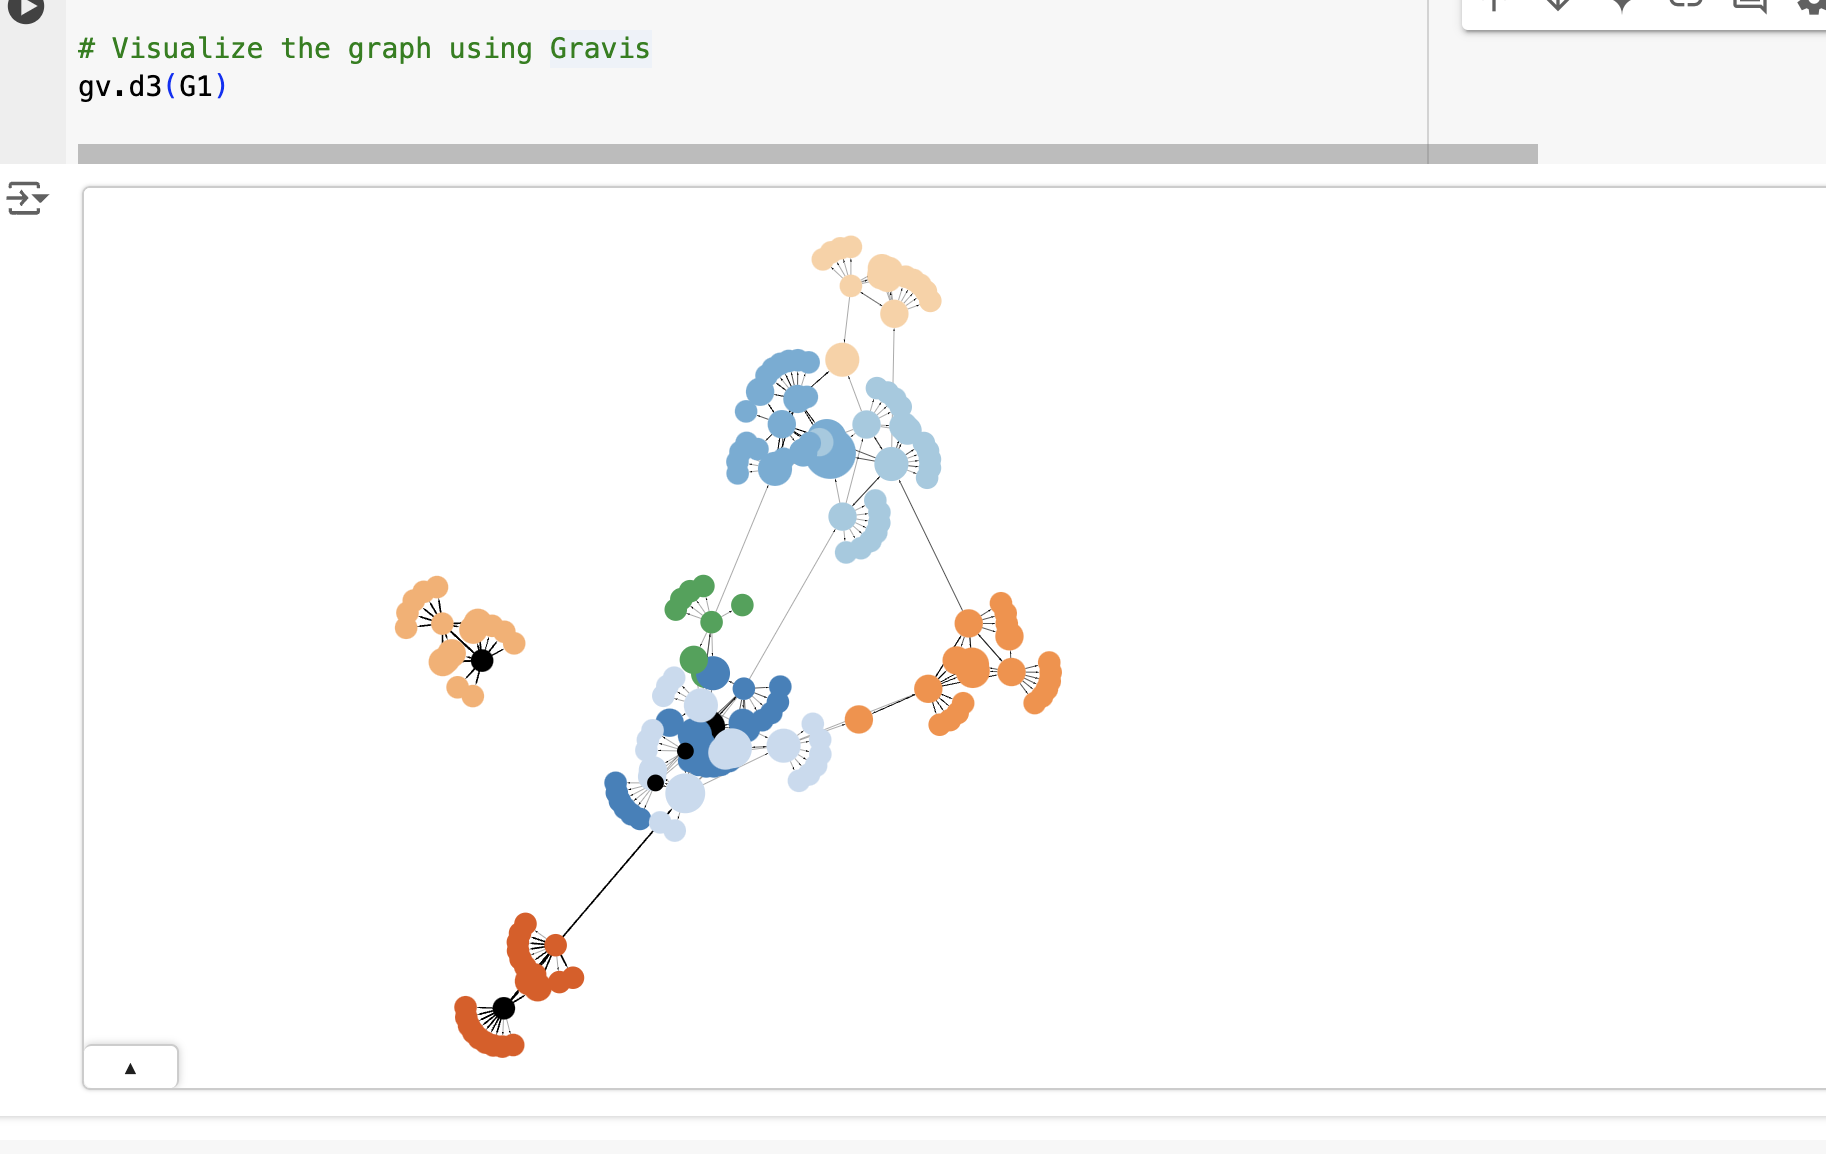

In [21]:

# Iterate through all weakly connected components in the graph
if nx.is_directed(G1):
    connected_components = list(nx.weakly_connected_components(G1))
else:
    connected_components = list(nx.connected_components(G1))

for i, component in enumerate(connected_components):
    print(f"\n=== Analysis for Connected Component {i + 1} ===")
    G1_subgraph = G1.subgraph(component).copy()  # Subgraph for the current component

    # Basic Network Properties
    num_nodes = G1_subgraph.number_of_nodes()
    num_edges = G1_subgraph.number_of_edges()
    density = nx.density(G1_subgraph)
    num_self_loops = nx.number_of_selfloops(G1_subgraph)
    isolates = list(nx.isolates(G1_subgraph))
    num_isolates = len(isolates)

    print(f"Number of Nodes: {num_nodes}")
    print(f"Number of Edges: {num_edges}")
    print(f"Density: {density:.4f}")
    print(f"Number of Self-loops: {num_self_loops}")
    print(f"Number of Isolated Nodes: {num_isolates}")

    # Degree Metrics
    in_degree = dict(G1_subgraph.in_degree())
    out_degree = dict(G1_subgraph.out_degree())

    # Top-K Nodes by Degree
    top_in_degree = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:5]
    top_out_degree = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:5]

    print("\nTop 5 Nodes by In-Degree:")
    for node, deg in top_in_degree:
        print(f"Node: {node}, In-Degree: {deg}")

    print("\nTop 5 Nodes by Out-Degree:")
    for node, deg in top_out_degree:
        print(f"Node: {node}, Out-Degree: {deg}")

    # Centrality Metrics
    in_degree_centrality = nx.in_degree_centrality(G1_subgraph)
    out_degree_centrality = nx.out_degree_centrality(G1_subgraph)
    betweenness_centrality = nx.betweenness_centrality(G1_subgraph)
    closeness_centrality = nx.closeness_centrality(G1_subgraph)

    # Top-K Nodes by Centrality
    top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

    print("\nTop 5 Nodes by Betweenness Centrality:")
    for node, cent in top_betweenness:
        print(f"Node: {node}, Betweenness Centrality: {cent:.4f}")

    print("\nTop 5 Nodes by Closeness Centrality:")
    for node, cent in top_closeness:
        print(f"Node: {node}, Closeness Centrality: {cent:.4f}")


    # Connectivity
    if nx.is_directed(G1):
        is_strongly_connected = nx.is_strongly_connected(G1_subgraph)
        is_weakly_connected = nx.is_weakly_connected(G1_subgraph)
    else:
        is_strongly_connected = is_weakly_connected = nx.is_connected(G1_subgraph)

    if is_weakly_connected or is_strongly_connected:
        try:
            diameter = nx.diameter(G1_subgraph.to_undirected())
            avg_shortest_path_length = nx.average_shortest_path_length(G1_subgraph.to_undirected())
            print(f"\nDiameter: {diameter}")
            print(f"Average Shortest Path Length: {avg_shortest_path_length:.4f}")
        except Exception as e:
            print(f"Error in computing diameter or average shortest path length: {e}")
    else:
        print("\nDiameter and Average Shortest Path Length are undefined for disconnected graphs.")



=== Analysis for Connected Component 1 ===
Number of Nodes: 158
Number of Edges: 223
Density: 0.0090
Number of Self-loops: 0
Number of Isolated Nodes: 0

Top 5 Nodes by In-Degree:
Node: BIv71MsdFVs, In-Degree: 6
Node: DOH-HNotTaE, In-Degree: 4
Node: xzZPzmMtQA8, In-Degree: 4
Node: 1rh-P2N0DR4, In-Degree: 4
Node: OJ6yd5mmuAU, In-Degree: 3

Top 5 Nodes by Out-Degree:
Node: TXxP8rAgWnM, Out-Degree: 13
Node: OJ6yd5mmuAU, Out-Degree: 12
Node: MULrP0nEIM4, Out-Degree: 12
Node: 7ZhdXgRfxHI, Out-Degree: 12
Node: NMHiLvirCb0, Out-Degree: 12

Top 5 Nodes by Betweenness Centrality:
Node: 7ZhdXgRfxHI, Betweenness Centrality: 0.0191
Node: Ra3h6yKLSq4, Betweenness Centrality: 0.0161
Node: xXnW4pD0OrA, Betweenness Centrality: 0.0156
Node: 5dqrOSk-Wyk, Betweenness Centrality: 0.0144
Node: 1rh-P2N0DR4, Betweenness Centrality: 0.0123

Top 5 Nodes by Closeness Centrality:
Node: BIv71MsdFVs, Closeness Centrality: 0.0451
Node: xzZPzmMtQA8, Closeness Centrality: 0.0411
Node: v6YEKYIkrzI, Closeness Centrali

In [22]:
# Perform community detection on the entire graph (without splitting into connected components)
communities = list(nx.algorithms.community.greedy_modularity_communities(G1.to_undirected()))
community_sizes = [len(community) for community in communities]
modularity_score = nx.algorithms.community.modularity(G1.to_undirected(), communities)

# Community Analysis
print("\nCommunity Analysis for Entire Graph:")
print(f"Number of Communities Detected: {len(communities)}")
print(f"Modularity Score: {modularity_score:.4f}")
print("\nCommunity Sizes:")
for idx, size in enumerate(community_sizes):
    print(f"Community {idx}: {size} nodes")

# Sample Nodes from Each Community
print("\nSample Nodes from Each Community:")
for idx, community in enumerate(communities):
    print(f"Community {idx}: Sample Nodes: {list(community)[:5]}")



Community Analysis for Entire Graph:
Number of Communities Detected: 9
Modularity Score: 0.7750

Community Sizes:
Community 0: 25 nodes
Community 1: 22 nodes
Community 2: 22 nodes
Community 3: 22 nodes
Community 4: 22 nodes
Community 5: 21 nodes
Community 6: 17 nodes
Community 7: 16 nodes
Community 8: 8 nodes

Sample Nodes from Each Community:
Community 0: Sample Nodes: ['bhxDdmZ9AwE', 'C8nAEjhobgA', '9sLxsIYjxrk', 'P3RWXEvaiwo', 'hCUm2TryvcY']
Community 1: Sample Nodes: ['GJGd4Csgo6A', 'DyoVVSggPjY', 'YpKej05RgsY', 'SK4kMPmgKW0', 'tm7poMupE8k']
Community 2: Sample Nodes: ['BASbIdt6p1I', 'xk48z8N-sl0', '7ZhdXgRfxHI', 'dSsubsLx2ZA', 'btIE9F0byNs']
Community 3: Sample Nodes: ['XC5ssX_RZa0', 'xXnW4pD0OrA', 'fW3u7LbD5E4', 'kSnfYSTpWxY', 'cfT7P9Vdq7o']
Community 4: Sample Nodes: ['D-qZyAZHoWk', '8HNgIJqeyDw', 'MDHw9mHSQ4o', '9mzqkSZakIk', 'fg3yUEcJweA']
Community 5: Sample Nodes: ['oTQNPojcfN4', '9E0tESCskO4', 'QLh1tnvDCdw', 'Io2w3xYpsSw', 'b0KJ327P0VY']
Community 6: Sample Nodes: ['o_TKIM

# depth<=5

In [23]:
# NetWork Contruction

# Depth threshold
max_depth = 5

# Initialize a directed graph
G2 = nx.DiGraph()

# Dictionary to track edge frequencies
edge_frequencies = {}

# Add nodes and edges with attributes (filter by depth)
for _, row in df.iterrows():
    source = row['Source Video ID']
    target = row['Target Video ID']
    depth = int(row['Depth']) if pd.notna(row['Depth']) else 0  # Default depth to 0

    # Skip nodes and edges beyond the max depth
    if depth > max_depth:
        continue

    # Track edge frequencies
    if (source, target) not in edge_frequencies:
        edge_frequencies[(source, target)] = 0
    edge_frequencies[(source, target)] += 1

    # Add source and target nodes
    G2.add_node(source, depth=depth)
    G2.add_node(target, depth=depth)

    # Add edges with attributes
    edge_color = "red" if source == target else "black"  # Mark self-loops as red
    G2.add_edge(source, target, size=edge_frequencies[(source, target)], color=edge_color)

In [24]:
# Compute modularity classes using greedy_modularity_communities
communities = greedy_modularity_communities(G2.to_undirected())  # Convert to undirected for modularity computation
modularity_classes = {node: idx for idx, community in enumerate(communities) for node in community}  # Map nodes to community IDs
modularity_colors = cm.tab20c.colors  # Predefined color palette for modularity

# Map modularity classes to colors
class_to_color = {mod_class: to_hex(modularity_colors[i % len(modularity_colors)]) for i, mod_class in enumerate(set(modularity_classes.values()))}

# Update node attributes
base_size = 50
influence_multiplier = 3000  # Amplify influence for larger nodes
for node in G2.nodes:
    # Assign size based on centrality
    centrality = nx.in_degree_centrality(G2)[node]
    G2.nodes[node]["size"] = base_size + (centrality * influence_multiplier)

    # Assign color
    if node in seed_list:
        G2.nodes[node]["color"] = "black"  # Seed nodes are black
        G2.nodes[node]["label"] = node  # Show label for seed nodes
        G2.nodes[node]["title"] = f"Seed: {node}"
    else:
        # Non-seed nodes get modularity-based color
        mod_class = modularity_classes.get(node, 0)  # Default to modularity class 0 if not found
        G2.nodes[node]["color"] = class_to_color[mod_class]
        G2.nodes[node]["label"] = ""  # Hide labels for non-seed nodes
        G2.nodes[node]["title"] = f"Video ID: {node}, Modularity Class: {mod_class}"  # Tooltip

# Update edge thickness based on raw frequency
for source, target, data in G2.edges(data=True):
    raw_width = edge_frequencies[(source, target)]  # Use raw edge frequency
    data["width"] = max(2, raw_width)  # Ensure a minimum width of 2 for visibility
    if data.get("color") == "red":  # Preserve red for self-loops
        data["color"] = "red"

# Visualize the graph using Gravis
gv.d3(G2)


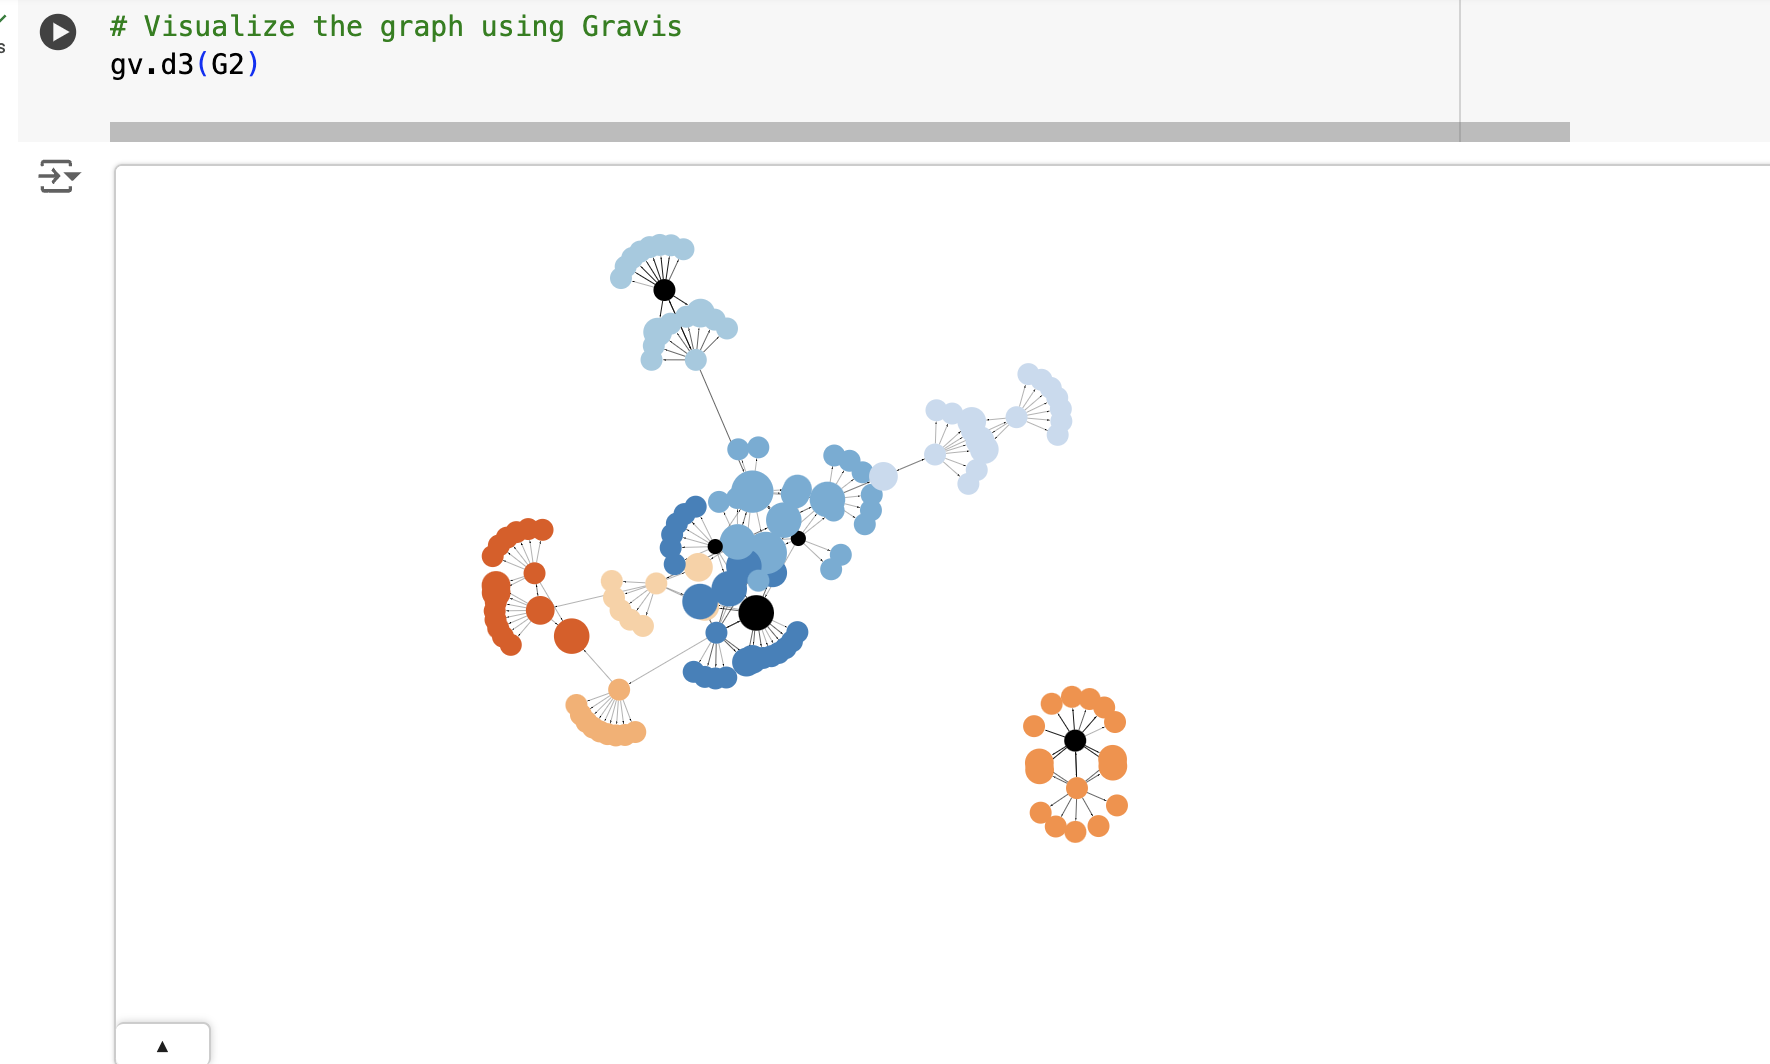

In [25]:
# Iterate through all weakly connected components in the graph
if nx.is_directed(G2):
    connected_components = list(nx.weakly_connected_components(G2))
else:
    connected_components = list(nx.connected_components(G2))

for i, component in enumerate(connected_components):
    print(f"\n=== Analysis for Connected Component {i + 1} ===")
    G2_subgraph = G2.subgraph(component).copy()  # Subgraph for the current component

    # Basic Network Properties
    num_nodes = G2_subgraph.number_of_nodes()
    num_edges = G2_subgraph.number_of_edges()
    density = nx.density(G2_subgraph)
    num_self_loops = nx.number_of_selfloops(G2_subgraph)
    isolates = list(nx.isolates(G2_subgraph))
    num_isolates = len(isolates)

    print(f"Number of Nodes: {num_nodes}")
    print(f"Number of Edges: {num_edges}")
    print(f"Density: {density:.4f}")
    print(f"Number of Self-loops: {num_self_loops}")
    print(f"Number of Isolated Nodes: {num_isolates}")

    # Degree Metrics
    in_degree = dict(G2_subgraph.in_degree())
    out_degree = dict(G2_subgraph.out_degree())

    # Top-K Nodes by Degree
    top_in_degree = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:5]
    top_out_degree = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:5]

    print("\nTop 5 Nodes by In-Degree:")
    for node, deg in top_in_degree:
        print(f"Node: {node}, In-Degree: {deg}")

    print("\nTop 5 Nodes by Out-Degree:")
    for node, deg in top_out_degree:
        print(f"Node: {node}, Out-Degree: {deg}")

    # Centrality Metrics
    in_degree_centrality = nx.in_degree_centrality(G2_subgraph)
    out_degree_centrality = nx.out_degree_centrality(G2_subgraph)
    betweenness_centrality = nx.betweenness_centrality(G2_subgraph)
    closeness_centrality = nx.closeness_centrality(G2_subgraph)

    # Top-K Nodes by Centrality
    top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

    print("\nTop 5 Nodes by Betweenness Centrality:")
    for node, cent in top_betweenness:
        print(f"Node: {node}, Betweenness Centrality: {cent:.4f}")

    print("\nTop 5 Nodes by Closeness Centrality:")
    for node, cent in top_closeness:
        print(f"Node: {node}, Closeness Centrality: {cent:.4f}")

    # Connectivity
    if nx.is_directed(G2):
        is_strongly_connected = nx.is_strongly_connected(G2_subgraph)
        is_weakly_connected = nx.is_weakly_connected(G2_subgraph)
    else:
        is_strongly_connected = is_weakly_connected = nx.is_connected(G2_subgraph)

    if is_weakly_connected or is_strongly_connected:
        try:
            diameter = nx.diameter(G2_subgraph.to_undirected())
            avg_shortest_path_length = nx.average_shortest_path_length(G2_subgraph.to_undirected())
            print(f"\nDiameter: {diameter}")
            print(f"Average Shortest Path Length: {avg_shortest_path_length:.4f}")
        except Exception as e:
            print(f"Error in computing diameter or average shortest path length: {e}")
    else:
        print("\nDiameter and Average Shortest Path Length are undefined for disconnected graphs.")



=== Analysis for Connected Component 1 ===
Number of Nodes: 118
Number of Edges: 154
Density: 0.0112
Number of Self-loops: 0
Number of Isolated Nodes: 0

Top 5 Nodes by In-Degree:
Node: DOH-HNotTaE, In-Degree: 4
Node: 1rh-P2N0DR4, In-Degree: 4
Node: OJ6yd5mmuAU, In-Degree: 3
Node: sHKXlAnVgo8, In-Degree: 3
Node: j8ObddnFBPg, In-Degree: 3

Top 5 Nodes by Out-Degree:
Node: OJ6yd5mmuAU, Out-Degree: 12
Node: MULrP0nEIM4, Out-Degree: 12
Node: 8D4SjiKazqk, Out-Degree: 11
Node: gJntKcGKsB4, Out-Degree: 10
Node: _36bHzl-PV0, Out-Degree: 10

Top 5 Nodes by Betweenness Centrality:
Node: 1rh-P2N0DR4, Betweenness Centrality: 0.0148
Node: Z_6A44lZwc4, Betweenness Centrality: 0.0137
Node: xXnW4pD0OrA, Betweenness Centrality: 0.0125
Node: MDn3DRaEo0U, Betweenness Centrality: 0.0102
Node: Ra3h6yKLSq4, Betweenness Centrality: 0.0094

Top 5 Nodes by Closeness Centrality:
Node: DOH-HNotTaE, Closeness Centrality: 0.0475
Node: C8nAEjhobgA, Closeness Centrality: 0.0407
Node: xKIMKN2NnPQ, Closeness Centrali

In [27]:
# Perform community detection on the entire graph (without splitting into connected components)
communities = list(nx.algorithms.community.greedy_modularity_communities(G2.to_undirected()))
community_sizes = [len(community) for community in communities]
modularity_score = nx.algorithms.community.modularity(G2.to_undirected(), communities)

# Community Analysis
print("\nCommunity Analysis for Entire Graph:")
print(f"Number of Communities Detected: {len(communities)}")
print(f"Modularity Score: {modularity_score:.4f}")
print("\nCommunity Sizes:")
for idx, size in enumerate(community_sizes):
    print(f"Community {idx}: {size} nodes")

# Sample Nodes from Each Community
print("\nSample Nodes from Each Community:")
for idx, community in enumerate(communities):
    print(f"Community {idx}: Sample Nodes: {list(community)[:5]}")


Community Analysis for Entire Graph:
Number of Communities Detected: 8
Modularity Score: 0.7585

Community Sizes:
Community 0: 25 nodes
Community 1: 22 nodes
Community 2: 18 nodes
Community 3: 18 nodes
Community 4: 17 nodes
Community 5: 17 nodes
Community 6: 10 nodes
Community 7: 8 nodes

Sample Nodes from Each Community:
Community 0: Sample Nodes: ['bhxDdmZ9AwE', 'C8nAEjhobgA', '9sLxsIYjxrk', 'P3RWXEvaiwo', 'hCUm2TryvcY']
Community 1: Sample Nodes: ['XC5ssX_RZa0', 'xXnW4pD0OrA', 'fW3u7LbD5E4', 'kSnfYSTpWxY', 'cfT7P9Vdq7o']
Community 2: Sample Nodes: ['D-qZyAZHoWk', '8HNgIJqeyDw', '9mzqkSZakIk', 'fg3yUEcJweA', '8D4SjiKazqk']
Community 3: Sample Nodes: ['oTQNPojcfN4', '9E0tESCskO4', 'QLh1tnvDCdw', 'b0KJ327P0VY', 'k3QiW0gEpYM']
Community 4: Sample Nodes: ['GJGd4Csgo6A', 'DyoVVSggPjY', 'xk48z8N-sl0', 'tm7poMupE8k', 'EgMHtALvsA4']
Community 5: Sample Nodes: ['o_TKIM1vUEs', 'Oo6iAxf4si0', '45ETZ1xvHS0', 'MRI8ffYKA8c', 'JRaakIL-N_s']
Community 6: Sample Nodes: ['ARaZROhkug4', 'r10g5gERB04',